In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas
from io import StringIO
import sympy
import scipy
from sklearn.preprocessing import normalize
from pathlib import Path

In [ ]:
# Funcion para correr .cpp

TP = "../src/main"
TEST_DIR = "../tests/"

def run_test(test_name: str, niter: int, eps: float): 
    !{TP} {TEST_DIR + test_name} {niter} {eps}

def run_test_pca(test_name: str, niter: int, eps: float, cant: int): 
    !{TP} {TEST_DIR + test_name} {niter} {eps} {cant}

def read_result_autovalores(test_result: str):
    return pandas.read_csv(TEST_DIR + test_result + '_autovalores.out', names=["autovalores"])

def read_result_autovectores(test_result: str):
    return pandas.read_csv(TEST_DIR + test_result + '_autovectores.out' , names=["autovectores"])

### 1. Tests metodo de la potencia

In [ ]:
# CASO SIMETRICO
A = np.array([
  [ 7,  2,  -3],
  [ 2,  2,  -2],
  [-3, -2,  -2]
])

# GUARDO TXT
np.savetxt("../tests/simetrico.txt", A, delimiter=' ')

# CORRO METODO
run_test("simetrico.txt", 100000, 1e-21)

# CARGO AUTOVALORES Y AUTOVECTORES
l = np.loadtxt("../tests/simetrico.txt_autovalores.out", dtype='f', delimiter=' ')
v = np.loadtxt("../tests/simetrico.txt_autovectores.out", dtype='f', delimiter=' ', usecols=range(3))

print(l)
print(v)


print(A @ v[:, 0])
print(l[0] * v[:,0])

for i in range(len(A)):
    print(i)
    print(np.allclose(A @ v[:, i], l[i] * v[:,i], 1e-6))


In [ ]:
# CASO (A) * (A traspuesta)
AT = A @ A.T
TA = A.T @ A

# GUARDO TXT
np.savetxt("../tests/AT.txt", AT, delimiter=' ')
np.savetxt("../tests/TA.txt", TA, delimiter=' ')

# CORRO METODO
run_test("AT.txt", 100000, 1e-21)
run_test("TA.txt", 100000, 1e-21)

# CARGO AUTOVALORES Y AUTOVECTORES
l_AT = np.loadtxt("../tests/AT.txt_autovalores.out", dtype='f', delimiter=' ')
v_AT = np.loadtxt("../tests/AT.txt_autovectores.out", dtype='f', delimiter=' ', usecols=range(3))

l_TA = np.loadtxt("../tests/TA.txt_autovalores.out", dtype='f', delimiter=' ')
v_TA = np.loadtxt("../tests/TA.txt_autovectores.out", dtype='f', delimiter=' ', usecols=range(3))

print(l_AT)
print(l_TA)
print("Bingo :)" if np.allclose(l_AT,l_TA) else "Bongo :(")
print("Bingo :)" if np.allclose(v_AT,v_TA) else "Bongo :(")

### Ej 2 Juli

### PCA

In [ ]:
paths = []
imgs = []
for path in sorted(list(Path('caras').rglob('*/*.pgm'))):
    paths.append(path)
    imgs.append(plt.imread(path)[::2,::2]/255)
X = np.stack(imgs)

In [ ]:
n = X.shape[0] # Cantidad de imagenes

X = X.reshape(n, -1) # X pasa a tener dimension n x (46 x 56)

X_centered = X - X.mean(0) # X.mean(0) devuelve un arreglo con la media de cada columna.

Mx = X_centered.T@X_centered/(n-1)  # Mx = Matriz de covarianza

# Calculo autovalores con numpy
# l, V = np.linalg.eigh(Mx)

# GUARDO TXT
#np.savetxt("../tests/pca.txt", Mx, fmt="%1.16e", delimiter=' ')

# CORRO METODO
#run_test("pca.txt", 10000, 1e-5)
#run_test_pca("pca.txt", 100000, 1e-16, 409)      # Con tolerancia 1e-16 converge rapido, con 1e-17 ya no

# CARGO AUTOVALORES Y AUTOVECTORES
#l = np.loadtxt("../tests/pca.txt_autovalores.out", dtype='f', delimiter=' ')
#v = np.loadtxt("../tests/pca.txt_autovectores.out", dtype='f', delimiter=' ', usecols=range(3))

#print(l)


In [13]:
# Comparo mis autovalores con numpy

l = np.loadtxt("../tests/pca.txt_autovalores.out", dtype='f', delimiter=' ')
v = np.loadtxt("../tests/pca.txt_autovectores.out", dtype='f', delimiter=' ', usecols=range(409))

l_np, v_np = np.linalg.eigh(Mx)

# Invierto el orden y me quedo con los 409 primeros
l_np = (np.flipud(l_np))[:409]  
v_np = (np.fliplr(v_np))[:, :409]

# for i in range(v.shape[1]):
#     print(i)
#     print(np.allclose(Mx @ v[:, i], l[i] * v[:,i], 1e-3))

# for i in range(v.shape[1]):
#     print(i)
#     print(np.allclose(Mx @ v_np[:, i], l_np[i] * v_np[:,i]))

### 2) b) PCA

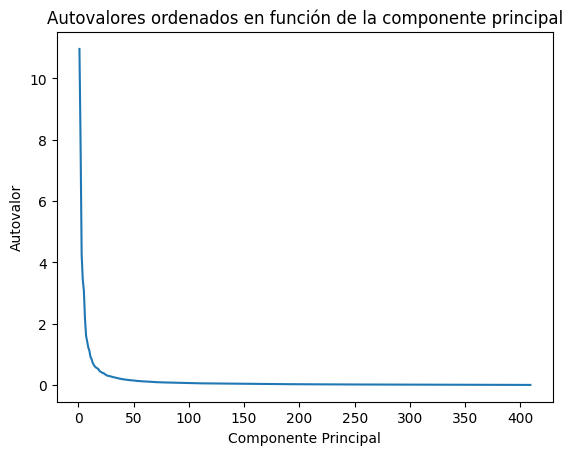

In [16]:
# Grafico los autovalores ordenados en función de las componentes principales
plt.plot(np.arange(1, len(l) + 1), l)
plt.xlabel('Componente Principal')
plt.ylabel('Autovalor')
plt.title('Autovalores ordenados en función de la componente principal')
plt.show()


### =======================================================================================

### 2DPCA

In [ ]:
paths = []
imgs = []
for path in sorted(list(Path('caras').rglob('*/*.pgm'))):
    paths.append(path)
    imgs.append(plt.imread(path)[::,::]/255)
X = np.stack(imgs)

La variante 2DPCA 2 considera una imagen en su espacio original como una matriz A ∈ Ra×b
y le asocia un feature vector Y ∈ Ra, mediante la transformacion lineal Y = AX siendo
X ∈ Rb el vector que maximiza la dispersion de los features vectors obtenidos para todo el
conjunto de imagenes. Se puede ver que la eleccion  ́optima para el vector de proyeccion X
se corresponde con el autovector de maximo autovalor de la denominada image covariance
matrix

In [ ]:
print(f"Tengo {X.shape[0]} imagenes de tamano {X.shape[1]}x{X.shape[2]}")
# A es la imagen
imgs = X

n = imgs.shape[0] # Cantidad de imagenes

A_prom = np.zeros(shape=(imgs.shape[1], imgs.shape[2]))

for i in range (n):
    A_prom += imgs[i]

A_prom /= n


# G = image covariance matrix (quiero calcularle autovalores y autovectores)
sum = 0
for j in range (n): 
    sum += (np.transpose(imgs[j] - A_prom)) @ (imgs[j] - A_prom)
G = (1/n) * sum

# GUARDO TXT
np.savetxt("../tests/2dpca_g.txt", G, delimiter=' ')

# CORRO METODO
run_test("2dpca_g.txt", 100000, 1e-21)

# CARGO AUTOVALORES Y AUTOVECTORES
l = np.loadtxt("../tests/2dpca_g.txt_autovalores.out", dtype='f', delimiter=' ')
v = np.loadtxt("../tests/2dpca_g.txt_autovectores.out", dtype='f', delimiter=' ', usecols=range(3))

print(l)

# V = matriz de feature vectors
# U = base de autovectores ortonormales de G
# V = imgs[0] @ U


# Quiero computar los Zi = (AiX1, AiX2, ..., AiXk) de cada imagen
# donde cada AiXk representa el k-esimo feature vector de la imagen Ai




In [ ]:
# Comparo mis autovalores con numpy
l = np.loadtxt("../tests/2dpca_g.txt_autovalores.out", dtype='f', delimiter=' ')
v = np.loadtxt("../tests/2dpca_g.txt_autovectores.out", dtype='f', delimiter=' ', usecols=range(G.shape[0]))

l_np, v_np = np.linalg.eigh(G)

l_np = (np.flipud(l_np))
v_np = (np.fliplr(v_np))


print(np.allclose(l, l_np))


print("======================")
print("Numpy: ")
print(G @ v_np[:, 0])
print(l_np[0] * v_np[:,0])
print("======================")
print("Mi solucion: ")
print(G @ v[:, 0])
print(l[0] * v[:, 0])


for i in range(v.shape[1]):
    print(i)
    print(np.allclose(G @ v[:, i], l[i] * v[:,i]))

for i in range(v.shape[1]):
    print(i)
    print(np.allclose(G @ v_np[:, i], l_np[i] * v_np[:,i]))

### 2) b) 2DPCA


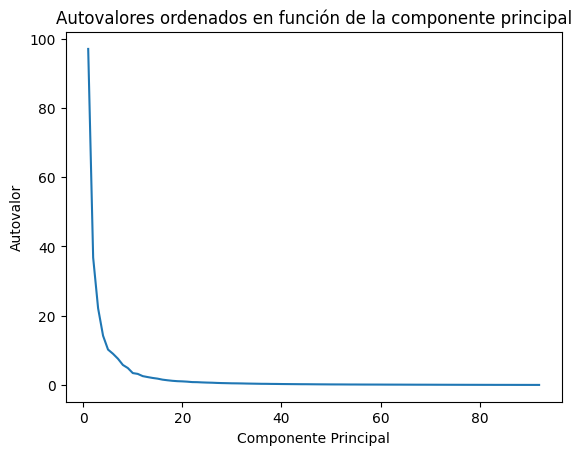

In [12]:
# Grafico los autovalores ordenados en función de las componentes principales
plt.plot(np.arange(1, len(l) + 1), l)
plt.xlabel('Componente Principal')
plt.ylabel('Autovalor')
plt.title('Autovalores ordenados en función de la componente principal')
plt.show()



### Ej 3